In [487]:
import pandas as pd
from pathlib import Path

# Visualizing 50k videos by 10k authors on TikTok

This is the original Jupyter notebook I used in the experiment. Code cells are mostly unchanged unless for clarity and readability. Many cells have been overwritten multiple times of course, so some detail in the progress is lost.

## Import Video metadata
Also, do some cleanup on nested data.

In [488]:
df = pd.read_json('./videos.json', lines=True)
df = df.join(pd.json_normalize(df['stats']))
df = df.join(pd.json_normalize(df['video']), rsuffix="vid")
df = df.join(pd.json_normalize(df['music']), rsuffix="mus")
df.challenges = df.challenges.apply(lambda x: [c['title'] for c in x])
df.drop(columns=['stats', 'video', 'music', 'idvid', 'idmus'], inplace=True)

## Poke around a bit to get a feel for the data

That part is mostly overwritten though.

<Axes: ylabel='Frequency'>

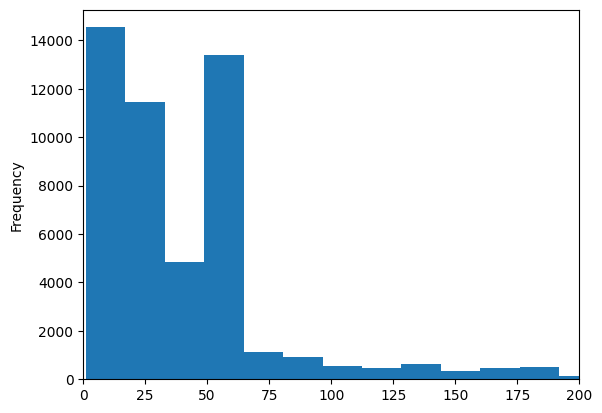

In [490]:
#df['play_count'].plot.hist(bins=50, xlim=(0, 200))
df['durationmus'].plot.hist(xlim=(0, 200))

/home/rob/miniconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='width', ylabel='height'>

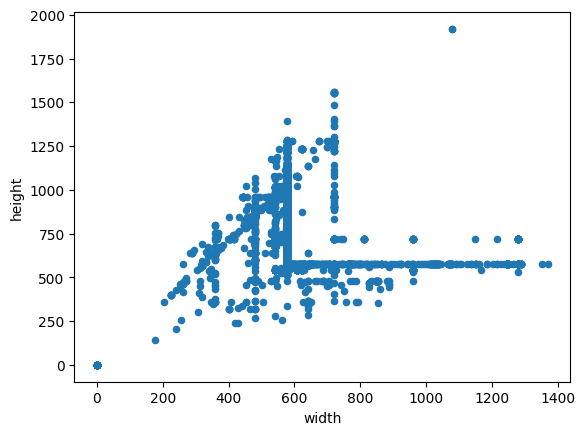

In [491]:
df.plot.scatter(x='width', y='height')

## Merge with transcribed text and language

in an ideal world, this would have happened before of course.

In [492]:
import json
df.drop(columns=['text', 'language'], inplace=True, errors='ignore')
def get_text_language(row):
    text, language = [None, None]
    try:
      id = row.id
      filename = f"./downloads/{id}.json"
      with open(filename, 'r') as json_file:
        data = json.load(json_file)
        text, language = [data['text'], data['language']]
    except FileNotFoundError:
      text, language = [None, None]
      
    return pd.Series([text, language],  index=['text', 'language'])
    
df = df.join(df.apply(get_text_language, axis=1))

## All this work for 715 german videos?

In [493]:
df.loc[df['language'] == 'de', ['language', 'text', 'id']]

language                                               text  \
111         de   Storytime! Und zwar, ich war gerade draußen m...   
132         de   Hiiii. So, ihr habt mich darum gebeten, dass ...   
161         de   Haram, haram, vor der Tür steht bald Ramadan ...   
178         de   Hey Leute, Storytime. Und zwar war ich letzte...   
180         de   Storytime. Ich wurde Anfang dieses Jahres von...   
...        ...                                                ...   
49895       de   In einer ganz aktuellen Meldung hat dieser bl...   
49899       de   Ich fang' das viel lieber an, vielleicht wird...   
49938       de   Was ist die eine Sache, die euer Expo euch ve...   
49971       de   Wie lang machst du dich fertig? Nicht mehr la...   
50085       de   Salamu alaikum, Marc-Sheikh Ibrahim, Dragonba...   

                        id  
111    6708034156065983749  
132    6713854796555619589  
161    6719412676897836294  
178    6724571818243476742  
180    6724631803803618566  
...                    ...  
49895  7226005038584401178  
49899  7226007281027009818  
49938  7226037616926330139  
49971  7226064314791234842  
50085  7226319226405997850  

[715 rows x 3 columns]

## Let's check out our focus account's content

"Warum haben die Muslime immer Krieg untereinander? Ja, weil die lieben westlichen europäischen, amerikanischen Staaten kommen, Feuer legen..." wieder was gelernt.


In [494]:
df.loc[df["author"] == "islamcontent5778"].text.values

array(['',
       ' Der Prophet Muhammad, salallahu öl Wer hat das allermeiste Recht, das sich Ihnen gut behandelt. Der Prophet Mohammed, salallahu öl worldsagte dasrennste Recht, woван eine Mutter�� dann sei tut er Okay, wherever des adaptingéqu screeif Die dej die palav durs Ergebegens Der Prophet the Prophet, der Deciden sagt noch einmal deiner Mud av Adanya mutta Deine Mutter Und da wurde er gefragt O Gesandte Allahs an vierter Stelle wer hat das größte Recht, das sich Ihnen gut behandelt Dann sagte er dein Vater Mutter, Mutter, Mutter Und dann dein Vater Diese Menschen musst du am allermeisten respektieren am allermeisten lieben am allermeisten schätzen am allermeisten beschenken Die haben das allermeiste verdient Und wenn du das machst Dann bist du ein richtig guter Muslim Inshaallah',
       ' Salam alaikum. Stimmt es, dass man 61 Tage nachfasten muss, wenn man seinen Fasten absichtlich bricht? Nach manchen Gelehrten muss man 61 oder 60 Tage nachfasten, wenn man seinen Fasten ab

## Next time, maybe a different scraping bias?

<Axes: >

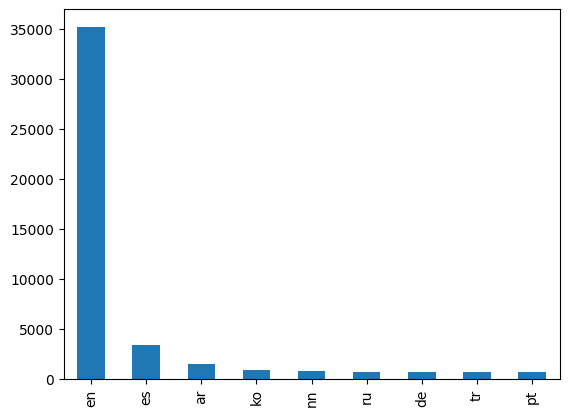

In [495]:
df.language.value_counts()[0:9].plot.bar()

## Let's get some embeddings

There's many embedding models out there, this one appears good-ish and is certainly fast enough, a run takes about 6 minutes

In [497]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L12-v2')

In [506]:
def embed(row):
  if row.text is None or row.text == '' or row.album is not None:
    return None
  else:
    return model.encode(row.text)

df['embeddings'] = df.apply(embed, axis=1)


## Move over to a new dataframe `tf` to avoid having to check for empty texts

Also, there is no chance to overlook typos between `df` and `tf`. Nope, none. 

In [563]:
tf = df.loc[(df['embeddings'].notnull()) & (df.album.isnull())]
tf.embeddings

3        [-0.064044066, -0.032103192, 0.09106987, -0.07...
4        [-0.0803851, 0.037114237, 0.10846759, 0.073299...
8        [-0.0010219268, -0.020478303, -0.003368347, -0...
11       [-0.02489485, 0.052500624, -0.030953132, 0.037...
12       [-0.0010219268, -0.020478303, -0.003368347, -0...
                               ...                        
50110    [-0.07802647, 0.10379703, 0.055530895, -0.0359...
50111    [-0.00025482968, 0.0041301553, 0.057955164, -0...
50112    [-0.05784398, 0.023627318, -0.08967374, 0.0168...
50116    [-0.07663534, -0.060016684, 0.08174831, 0.0231...
50118    [0.007653443, 0.07415405, 0.03473741, 0.115336...
Name: embeddings, Length: 35109, dtype: object

## So. Many. Numbers.

In [507]:
matrix = np.vstack(tf.embeddings.values)
matrix.shape

(35109, 384)

## Let's try to make it less numbers!

In [508]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
tf["Cluster"] = labels

/home/rob/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_1463313/3090333577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf["Cluster"] = labels


In [509]:
tsne = TSNE(n_components=2, perplexity=15, random_state=123, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

## OK, this is hacky af, but remember, it was meant as an experiment

Let's visualize the clusters, but highlight specific accounts in there on demand in red

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

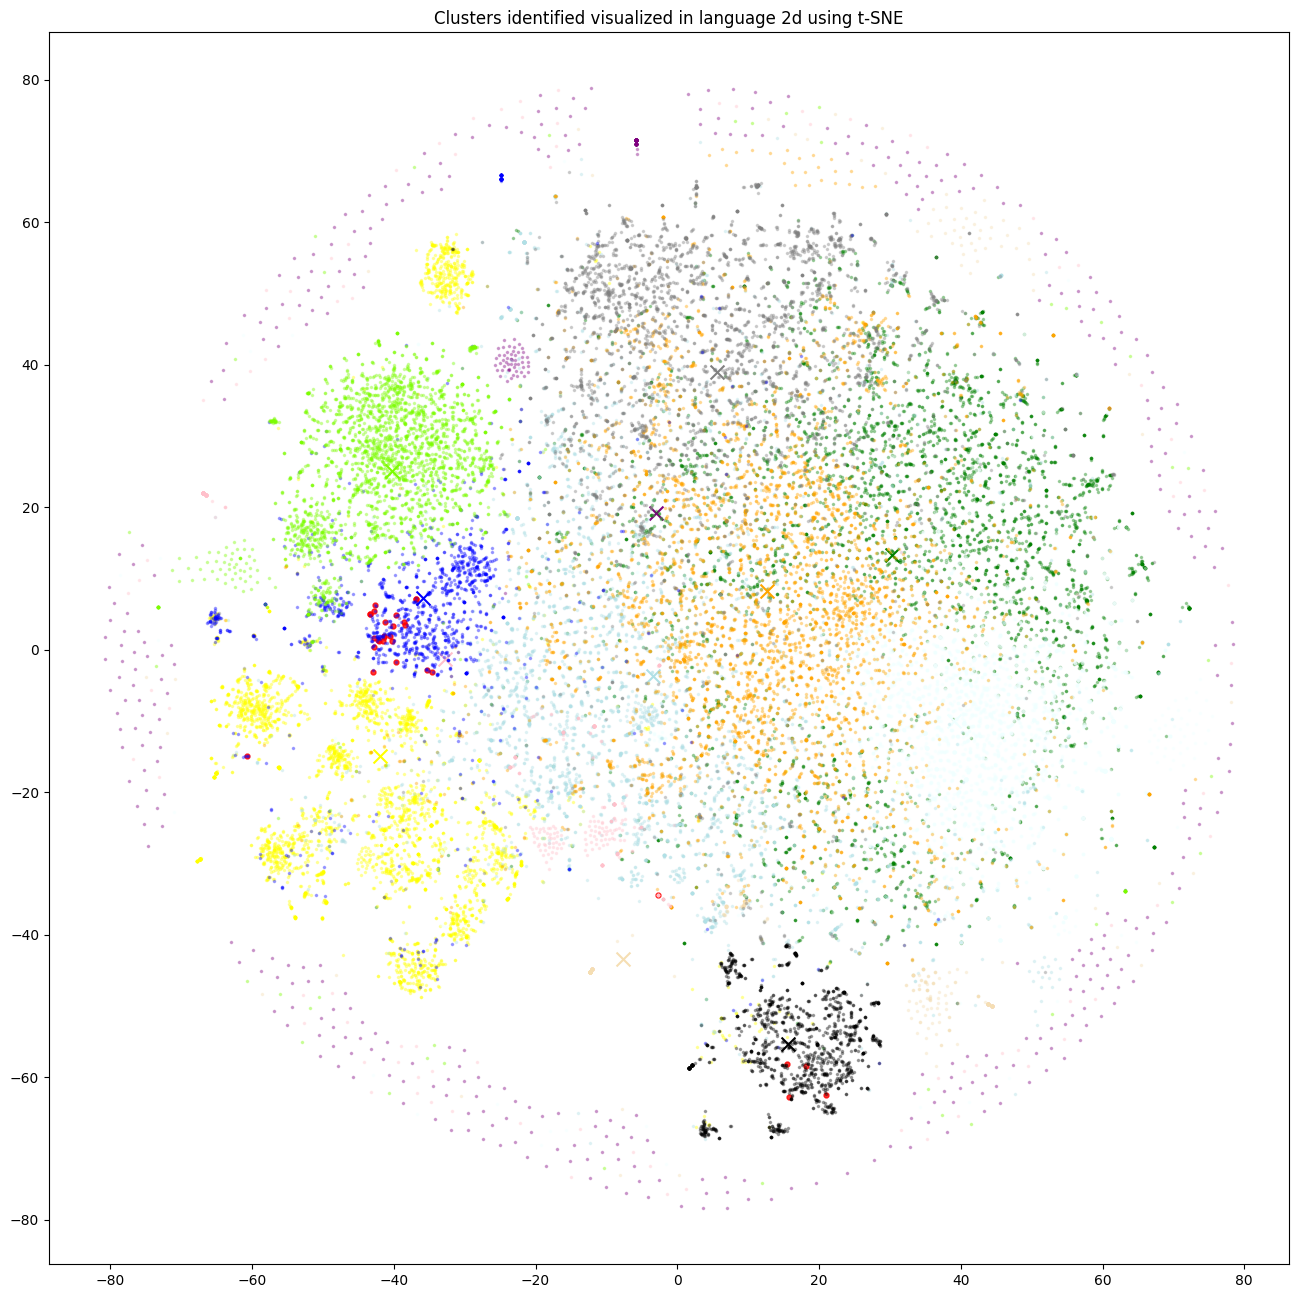

In [510]:
FOCUS="sheikh_ibrahim7"
plt.figure(figsize=(16,16))
si_x = np.array(x)[tf.author == FOCUS]
si_y = np.array(y)[tf.author == FOCUS]
plt.scatter(si_x, si_y, marker=".", color="red", alpha=0.8, s=50)


for category, color in enumerate(["purple", "green", "yellow", "azure", "powderblue", "orange", "pink", "wheat", "grey", "blue", "black", "lawngreen"]):
    xs = np.array(x)[(tf.Cluster == category) & (tf.author != FOCUS)]
    ys = np.array(y)[(tf.Cluster == category) & (tf.author != FOCUS)]
    plt.scatter(xs, ys, marker=".", color=color, alpha=0.3, s=10)


    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


## One account, two main topic clusters?

Interesting, let's see what happened there:

In [511]:
tf.loc[tf.author == "sheikh_ibrahim7", ["Cluster", "text"]]

Cluster                                               text
15294        9   Eine Person möchte wissen, ist im Islam Selbs...
15295        9   Zu Halb 216 möchte wissen, welche Tat liebt A...
19168        9   Wenn man einen Grund hat, einen Elternteil ni...
19177        9   Wie macht man die Tat wieder gut, wenn man Si...
19232        9   Es ist eine Nationalfrage, Kuffer, inshallah ...
19233        9   Wie bekomme ich hin, dass meine Frau auch bet...
19239        9   Assalamu alaikum warahmatullahi wabarakatuhu....
19332        9   Murat 848484 möchte wissen, gibt es eine Dua,...
19407        9   Nach dem 1, 2, 3 Mischung wissen, darf man in...
20143        9   V4900 möchte wissen, was ist deine Meinung üb...
20985        9   Eine Person möchte wissen, was ist, wenn man ...
23431        9   Assalamu alaikum liebe Geschwister. Diese Fra...
23432        9   Der Herr Türk kommentiert, wenn man von Chris...
27087        9   die frohe Botschaft mitgeteilt bekommen, dass...
27292        6                                        you you you
29602       10   إلى الله نمضي يهنيئا لمن سبق ويا حض قلب من تق...
29643        9   Wie stellst du dir dein ideales Ergebnis dein...
29698        9   Jetzt hast du das letzte Wort. Ich sage was d...
34616        9   Mark Schiribren, Zelda, das Spiel. Was, Zelda...
34617        9   Eure Meinung zu Imam Shamil und das kaukasisc...
34618        9   Gibt es eine islamische Sichtweise auf den Ba...
34619        9   Was sollte man machen, wenn beim Gebet neben ...
40687       10   لا تقول إنها بعيدة نفتح بلاد جديدة وهذا الفعل...
44953        9   Darf man Pornovideos schauen? Und wie ist das...
45783        9   Hast du Abi geschafft? Bei mir war es so, ich...
47045        9   Was hältst du von Kurden? Die Kurden sind ein...
47054        9   Was denkst du von den Türken? Also viele Türk...
47085       10   جمال الوجود بذكر الاناة وتصف الحياة بنور هداة...
48348        9   Was jetzt von Tschetschenern? Die meisten Tsc...
48349       10   السلام عليكم أيها القنصراء تخ ابي الله بال VC...

oh OK, two different languages, fair enough. Overall, very limited usefulness if we want to only find similar accounts or do any other real-world task. the nost frequent cluster `9` is shared by all kinds of accounts:

In [513]:
tf.loc[tf.Cluster == 9].author.value_counts()

islamcontent5778       31
detlefsteves           30
veganer_ethiklehrer    30
laschakv               29
julienrosburger        29
                       ..
netflix_.tiktok         1
fanpage.it              1
guitaronion             1
tomfusaz                1
footballvn035           1
Name: author, Length: 642, dtype: int64

## Let's slice'n'dice this a bit and look at authors

In [515]:
authors = tf.author.unique()
af = pd.DataFrame(authors, columns=["author"])
af

author
0          luismariz
1         collinskey
2           jenbrick
3       sumerjazmine
4          joonkatsu
...              ...
10141  unbekannt.akh
10142       _eneru12
10143  ditoio_javier
10144     briarmxlti
10145   singallising

[10146 rows x 1 columns]

## Average each author's text embeddings to get a more robust estimate of their content's topic

In [516]:
def get_author_embeddings(row):
  author = row.author
  embeddings = tf.loc[tf.author == author, "embeddings"]
  embeddings = embeddings.mean()
  return embeddings

af["embeddings"] = af.apply(get_author_embeddings, axis=1)

## Sum up all the author's plays

Another dimension to add to nodes to get some idea of their relevancy. This is a stopgap solution because we didn't get the data for authors from their profile page during scraping

In [546]:
def get_author_plays(row):
  author = row.author
  plays = df.loc[df.author == author, "play_count"]
  return plays.sum()

af["plays"] = af.apply(get_author_plays, axis=1)

## Get author's most frequently used language

In [545]:
def get_author_language(row):
  author = row.author
  language = df.loc[df.author == author].language.value_counts().keys()[0]
  return language

af["language"] = af.apply(get_author_language, axis=1)

## How close are the authors to our focus account in the vector-space?

Let's measure distance in 384 dimensional space! Euclidian because it's simpler to explain if someone asks, cosine distance or similar would probably be slightly better.

In [548]:
import scipy.spatial.distance as distance
a = af.iloc[7].embeddings
b = af.iloc[23].embeddings
distance.euclidean(a, b)

1.4192017316818237

## Measure author distance to our focus account

In [549]:

def get_distance_to_focus(row):
  ibrahim = af.loc[af.author == "islamcontent5778"]
  d = distance.euclidean(ibrahim.embeddings.values[0], row.embeddings)
  return d

af["distance"] = af.apply(get_distance_to_focus, axis=1)

## Approaching usefulnes

We can now sort our authors by similiarity to our focus account. Mixed results:

In [550]:
af.sort_values(by="distance").head(50)

author  \
9988          islamcontent5778   
5699           sheikh_ibrahim7   
6886        generation_islamgi   
9882               guru1045x3w   
4598                himbeer_pi   
6908                  laschakv   
8548                  gg_laros   
7960                 driprapde   
8445               finanzhacks   
8161       veganer_ethiklehrer   
6292                 twitch.xy   
5974         derislamverbindet   
3120          tochter_official   
8168    islam.ist.die.wahrheit   
4424              detlefsteves   
1691                julyanpohl   
8224               anothergian   
499                 herranwalt   
9568           yaum_al.qiyamah   
9804              mohamed__ino   
1404                    dnbmoo   
6895           circuitcrusader   
6067              manulove_you   
4532                  baku_737   
2142                  mrsflury   
7296              almost.cesca   
7925  militaneveganerinfanpage   
9885                  fe_fe130   
5546                   geo_shp   
1946                 lanabante   
7670                fil.editzz   
9265                morgane_hc   
5598            niallmacmillan   
9721               amandaaaphr   
6086               keith.nunes   
7197            laquequetterie   
7293               cooline_mtz   
685                sananaina11   
7802                    iaga00   
5383          netflix.serien30   
3381              xaroeditx.am   
5662                haftbefehl   
9200                   imsolal   
9942               thatricannp   
9314              kris_leontii   
3242                brainqueen   
91                     westr._   
1557              insertrichie   
6600      thecryptohustlers666   
8885                 jojo_cmpr   

                                             embeddings      plays language  \
9988  [-0.019193925, 0.061651953, -0.01290362, 0.007...    9786700       de   
5699  [-0.011152617, 0.06699396, -0.029430712, 0.017...     750488       de   
6886  [-0.017364355, 0.06676653, -0.026740072, 0.023...     318102       de   
9882  [-0.022193233, 0.073931776, -0.03240143, 0.026...     302373       de   
4598  [-0.018365556, 0.0634831, 0.010078511, 0.01268...     286143       de   
6908  [-0.0023175678, 0.051612545, -0.016311623, 0.0...   33097400       de   
8548  [-0.021711476, 0.046347868, -0.012099705, 0.02...     915245       de   
7960  [-0.027211305, 0.06406172, -0.0061401157, 0.01...    3990800       de   
8445  [-0.018044764, 0.035024043, 0.0045134234, 0.00...    6796505       de   
8161  [-0.016992848, 0.040000595, -0.021730607, 0.01...      70714       de   
6292  [-0.03780639, 0.06341276, -0.0008158102, 0.015...    6375600       de   
5974  [-0.025864284, 0.06634589, 0.0065132733, -0.00...      73042       de   
3120  [-0.044861533, 0.04450289, -0.0015111587, 0.01...     121635       de   
8168  [-0.022427356, 0.075676605, -0.03204438, 0.000...     925020       de   
4424  [-0.022464236, 0.07687594, -0.015555492, 0.025...   34123900       de   
1691  [-0.015677912, 0.042528648, 0.0153611405, 0.01...   53124000       de   
8224  [-0.012512826, 0.02749006, -0.008744188, -0.00...    5850201       de   
499   [-0.04939606, 0.016599547, -0.020299524, -0.00...    9812700       de   
9568  [-0.023087386, 0.0856133, -0.029381666, -0.004...     214375       de   
9804  [-0.02491245, 0.07872866, -0.054968677, 0.0049...     267641       de   
1404  [-0.032652, 0.014045057, -0.0027380812, 0.0114...    2428200       de   
6895  [-0.028277116, 0.043916054, -0.006334272, -0.0...    9892891       en   
6067  [-0.008986808, 0.011402609, 0.022539586, 0.000...       7038       en   
4532  [-0.036178913, 0.028285744, -0.0013897206, -0....    3409086       en   
2142  [-0.03236734, -0.002235324, 0.008161392, 0.026...    3152397       en   
7296  [-0.037181187, 0.001083338, 0.015008722, 0.013...   33466600       en   
7925  [-0.024421055, 0.02003206, 0.017953105, -0.004...    2382148       en   
9885  [-0.022703553, 0.01920186, 0.031511515, -0.010...    4362822       en  

## Make it searchable

Put in vector, get back closest X vectors. Within limits, those databases do Approximate Neirest Neighbour in order to be fast. For such a small dataset however, you can safely pick the slowest but most exact algo.

Use it to index our `tf` dataframe, that's the videos with good texts.

In [551]:
import faiss
#index = faiss.IndexIDMap(faiss.IndexFlatIP(384))
index = faiss.IndexFlatIP(384)

In [552]:
vectors = tf.embeddings.values
vectors = np.vstack(vectors)
index.add(vectors)
vectors.shape

(35109, 384)

In [562]:
tf

id               create_time  \
3      6536712913493693440 2018-03-25 03:05:01+00:00   
4      6545505639429313551 2018-04-17 19:45:14+00:00   
8      6599619656888093957 2018-09-10 15:34:53+00:00   
11     6627228641551977734 2018-11-24 01:11:50+00:00   
12     6627722196175293701 2018-11-25 09:07:05+00:00   
...                    ...                       ...   
50110  7226431859796774171 2023-04-26 18:46:28+00:00   
50111  7226438034353294635 2023-04-26 19:10:27+00:00   
50112  7226446781654076678 2023-04-26 19:44:19+00:00   
50116  7226464799532617003 2023-04-26 20:54:21+00:00   
50118  7226484214269627674 2023-04-26 22:09:51+00:00   

                                                    desc  \
3                                             #KCAs 🔥❤️😍   
4      HAPPY BIRTHDAY @devankey  !! I’m BFFing people...   
8      Pug Plank Challenge #imakemyownrules #puglife ...   
11     Nickelodeon Universe 😁 #nickelodeanuniverse #n...   
12     #coffee #foodporn #food #daily #latte #barista...   
...                                                  ...   
50110      Baris effekt 😂 #barisbrevik #pokemonlegenden    
50111  Me and my girlies @angelina.dancer @vivster.28...   
50112  This is a sourdough account now FYI. 😂 #sourdo...   
50116  Replying to @trxppnl The Michael Jackson one i...   
50118  Who would win ? #tokyorevengers #tokyorevenger...   

       diversification_labels  \
3                         NaN   
4                         NaN   
8                         NaN   
11                        NaN   
12                        NaN   
...                       ...   
50110                     NaN   
50111                     NaN   
50112                     NaN   
50116                     NaN   
50118                     NaN   

                                              challenges image_post  \
3                                                 [kcas]       None   
4                                                     []       None   
8      [accepted, updownplank, puglife, 업다운플랭크, スーパーマ...       None   
11     [nickelodeanuniverse, nickelodean, backyardigans]       None   
12     [art, tiktok, kahveyaptım, barista, latteart, ...       None   
...                                                  ...        ...   
50110                     [pokemonlegenden, barisbrevik]       None   
50111                      [danceteacher, dancer, dance]       None   
50112  [sourdoughbeginner, sourdoughclub, sourdoughbr...       None   
50116  [horror, timeline, mandelaeffect, history, str...       None   
50118  [tokyorevengersedit, tokyorevengersfananimatio...       None   

                      author comments  digg_count  share_count  ...  \
3                  luismariz      NaN       64000           96  ...   
4                 collinskey      NaN      893400         4097  ...   
8                   jenbrick      NaN     2200000        78500  ...   
11              sumerjazmine      NaN       27800          891  ...   
12                 joonkatsu      NaN       82300          516  ...   
...                      ...      ...         ...          ...  ...   
50110                chrb166      NaN          82            2  ...   
50111  morganandlaurenpotter      NaN        1929            0  ...   
50112          itsjamiecoker      NaN           0            0  ...   
50116            khalilslife      NaN       22500          130  ...   
50118               yuriinai      NaN         212            1  ...   

       durationmus  original  album  \
3               15     False   None   
4               15     False   None   
8               15     False   None   
11              15     False   None   
12              31     False   None   
...            ...       ...    ...   
50110           49     False   None   
50111           17     False   None   
50112           22     False   None   
50116           80     False   None   
50118            9     False   None   

                                             cover_large  

## We have search!

We can create embeddings from any prompts and find similar embeddings, giving us a fancy search with the ids of our texts and similarities.

In [554]:
embeddings = model.encode("Hassprediger")
sim, ids = index.search(np.vstack([embeddings]), 50)

#tf.iloc[ids[0]].text.values
sim[0]

array([0.41137546, 0.3947285 , 0.39458346, 0.39386165, 0.39139313,
       0.37498692, 0.35516664, 0.3515161 , 0.32809022, 0.328044  ,
       0.3244965 , 0.3237232 , 0.3223416 , 0.31720626, 0.313406  ,
       0.3077687 , 0.30505642, 0.30327213, 0.3024978 , 0.30058035,
       0.30049384, 0.299563  , 0.299563  , 0.29889578, 0.29376382,
       0.29333115, 0.29333082, 0.29303277, 0.29303277, 0.29250556,
       0.2924551 , 0.29057777, 0.2900914 , 0.28990975, 0.28796118,
       0.28738844, 0.2854715 , 0.28523633, 0.28401995, 0.283059  ,
       0.28289774, 0.28279716, 0.28258842, 0.28085053, 0.2806766 ,
       0.28033885, 0.2801366 , 0.2794876 , 0.2779236 , 0.2777583 ],
      dtype=float32)

## Create a Graph

Now let's use this to create something that at least looks impressive and useful. We do have 10k authors with some metadata like total plays, language and similarity to our focus account (by distance of means of all text embeddings per author).

We can could cross-correlate authors by similarity of their mean embeddings, but we already saw that results in mixed results. So let's make it a bit more granular and for each text, find the most similar texts from other authors and create connections between authors by adding up similarity scores as weights. The more similar videos there are between two authors, the stronger the edge between is.

Networkx is using a performant structure for creating and updating nodes and edges and can directly export to Gephy for visualization, so let's try that: 

In [556]:
import networkx as nx

In [560]:
G = nx.Graph()
for idx, a in af.iterrows():
  G.add_node(a.author, plays=a.plays, distance=a.distance, language=a.language)

for idx, t in tf.iterrows():
  ids = index.search(np.vstack([t.embeddings]), 10)
  a = af[af.author == t.author].iloc[0]
  for iidx, i in enumerate(ids[1][0]):
    b = tf.iloc[i]
    
    if a.author == b.author:
      continue

    weight = ids[0][0][iidx]
    # filter out weak connections if we have at least 3 to avoid dangling nodes
    if weight < 0.5 and iidx > 3:
      continue

    # ugly hack to make sure we don't have duplicate edges through random orderings of th authors
    authors = [a.author, b.author]
    authors.sort()
    try:
      oldweight = G[authors[0]][authors[1]]['weight']
    except:
      oldweight = 0
    weight = weight + oldweight
    G.update(edges=[(authors[0], authors[1], { "weight": weight })])

In [476]:
G.size()

110434

# Done

This was fun, albeit only marginally useful. Let's build something useful together, next ;)

In [561]:
nx.write_gexf(G, "tiktok_graph.gexf")

### Using gephistreamer

Injects nodes and edges into Gephi live: Saves a few clicks but is slow AF for > 100k objects even through WS and tends to crash Gephi.

This was some early iteration, never finished and abandoned in favor of Networkx above.


In [272]:
from gephistreamer import graph, streamer
streamer = streamer.Streamer(streamer.GephiWS(workspace="workspace1"))

In [273]:
author_nodes = {}
for idx, a in af.iterrows():
  node = graph.Node(a.author, plays=a.plays, distance=a.distance, language=a.language)
  author_nodes[a.author] = node
  streamer.add_node(node)

In [290]:

for idx, a in af.iterrows():
  ids = index.search(np.vstack([a.embeddings]), 10)
  for iidx, i in enumerate(ids[1][0]):
    b = af.iloc[i]
    if i <= idx:
      continue
    
    weight = ids[0][0][iidx]
    if weight < 0.5:
      continue
    
    edge_ab = graph.Edge(author_nodes[a.author], author_nodes[b.author], weight=weight, directed=False)
    streamer.add_edge(edge_ab)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │                                                                                           │
│   12 │   weight = 1/weight                                                                       │
│   13 │                                                                                           │
│ ❱ 14 │   edge_ab = graph.Edge(author_nodes[a.author], author_nodes[b.author], weight=weight,     │
│   15 │   streamer.add_edge(edge_ab)                                                              │
│   16                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'luismariz'